In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import mpl_lego as mplego
import pandas as pd

from hatespeech.keys import *
from IPython.display import Markdown
from scipy.stats import f_oneway, kruskal

%matplotlib inline

In [3]:
mplego.style.use_latex_style()

In [4]:
exp = "07"
base_path = os.path.join(os.environ['HOME'], 'projects/hatespeech-2021-fairml')
data_path = os.path.join(os.environ['HOME'], 'data/hatespeech/clean_qualtrics_irt_rollout.feather')
results_path = os.path.join(base_path, f'scaling/experiments/exp{exp}')

In [5]:
data = pd.read_feather(data_path)

In [6]:
men_target_results_path = os.path.join(results_path, f"exp{exp}_scores_men.2.txt")
women_target_results_path = os.path.join(results_path, f"exp{exp}_scores_women.2.txt")

In [7]:
# Get severities for men-targeting comments
men_target_results = pd.read_csv(men_target_results_path, delimiter='\t', skiprows=1)
men_target_annotators = men_target_results['Judges']
men_target_severity = men_target_results['Measure']
# Get severities for women-targeting comments
women_target_results = pd.read_csv(women_target_results_path, delimiter='\t', skiprows=1)
women_target_annotators = women_target_results['Judges']
women_target_severity = women_target_results['Measure']

In [8]:
print(f'Men-targeting: {men_target_severity.shape}')
print(f'Women-targeting: {women_target_severity.shape}')

Men-targeting: (5684,)
Women-targeting: (8484,)


In [9]:
# Get annotators that looked at both men- and women- targeting comments
common_annotators = men_target_annotators[men_target_annotators.isin(women_target_annotators)].values
men_target_common = men_target_results[men_target_annotators.isin(common_annotators)]
women_target_common = women_target_results[women_target_annotators.isin(common_annotators)]
print(f'Common annotators: {common_annotators.shape}')

Common annotators: (5505,)


Text(0, 0.5, '\\textbf{Frequency}')

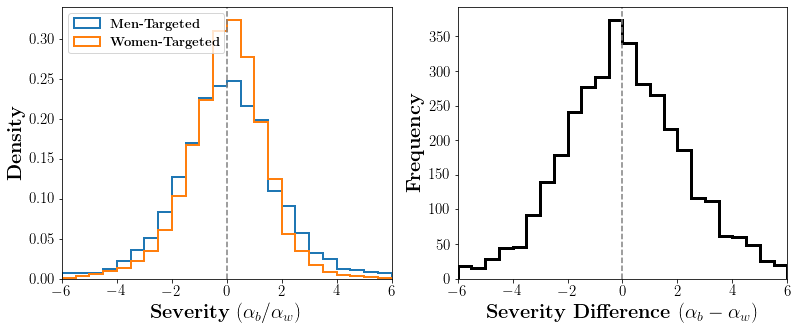

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5))

bins = np.linspace(-6, 6, 25)
axes[0].hist(
    men_target_severity,
    bins=bins,
    density=True,
    linewidth=2,
    color='C0',
    label=r'\textbf{Men-Targeted}',
    histtype='step')
axes[0].hist(
    women_target_severity,
    bins=bins,
    density=True,
    linewidth=2,
    color='C1',
    label=r'\textbf{Women-Targeted}',
    histtype='step')

axes[0].axvline(0, linestyle='--', color='grey')
axes[0].set_xlim([-6, 6])
axes[0].set_xlabel(r'\textbf{Severity} $(\alpha_b/\alpha_w)$', fontsize=20)
axes[0].set_ylabel(r'\textbf{Density}', fontsize=20)
axes[0].legend(loc=2, prop={'size': 13})
axes[0].tick_params(labelsize=15)

axes[1].hist(
    men_target_common['Measure'] - women_target_common['Measure'],
    bins=bins,
    histtype='step',
    linewidth=3,
    color='black')
axes[1].set_xlim([-6, 6])
axes[1].axvline(0, linestyle='--', color='grey')
axes[1].tick_params(labelsize=15)
axes[1].set_xlabel(r'\textbf{Severity Difference} $(\alpha_b - \alpha_w)$', fontsize=20)
axes[1].set_ylabel(r'\textbf{Frequency}', fontsize=20)
#plt.savefig('severities_bw03.pdf', bbox_inches='tight')

In [11]:
# men annotator severity difference
men_annotators = data[data[annotator_gender_col] == annotator_gender['male']]['labeler_id'].values
m_annotator_m_target_sev = men_target_common[men_target_common['Judges'].isin(men_annotators)]['Measure'].values
m_annotator_w_target_sev = women_target_common[women_target_common['Judges'].isin(men_annotators)]['Measure'].values
m_annotator_diffs = m_annotator_m_target_sev - m_annotator_w_target_sev
# women annotator severity difference
women_annotators = data[data[annotator_gender_col] == annotator_gender['female']]['labeler_id'].values
w_annotator_m_target_sev = men_target_common[men_target_common['Judges'].isin(women_annotators)]['Measure'].values
w_annotator_w_target_sev = women_target_common[women_target_common['Judges'].isin(women_annotators)]['Measure'].values
w_annotator_diffs = w_annotator_m_target_sev - w_annotator_w_target_sev

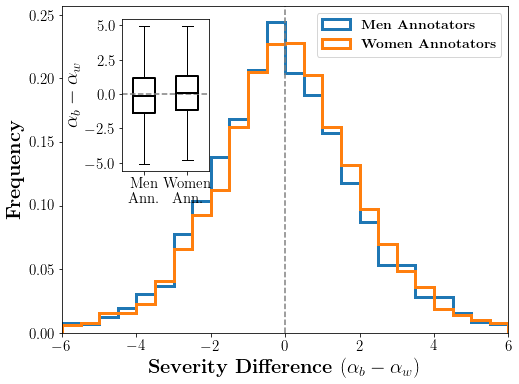

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

bins = np.linspace(-6, 6, 25)

ax.hist(
    m_annotator_diffs,
    bins=bins,
    histtype='step',
    linewidth=3,
    density=True,
    label=r'\textbf{Men Annotators}',
    color='C0')
ax.hist(
    w_annotator_diffs,
    bins=bins,
    histtype='step',
    linewidth=3,
    density=True,
    label=r'\textbf{Women Annotators}',
    color='C1')
ax.set_xlim([-6, 6])
ax.axvline(0, linestyle='--', color='grey')
ax.tick_params(labelsize=15)
ax.set_xlabel(r'\textbf{Severity Difference} $(\alpha_b - \alpha_w)$', fontsize=20)
ax.set_ylabel(r'\textbf{Frequency}', fontsize=20)
ax.legend(loc='best', prop={'size': 14})

inset = fig.add_axes([0.23, 0.5, 0.15, 0.35])
inset.boxplot(
    x=[m_annotator_diffs, w_annotator_diffs],
    showfliers=False,
    widths=0.5,
    medianprops={'color': 'black', 'lw': 2},
    boxprops={'lw': 2},)
inset.set_xticklabels(['Men\nAnn.', 'Women\nAnn.'])
inset.set_ylabel(r'$\alpha_b - \alpha_w$', fontsize=20)
inset.axhline(0, linestyle='--', color='gray')
inset.tick_params(labelsize=15)
#plt.savefig('men_vs_women_annotators_bw03.pdf', bbox_inches='tight')

# All Identity Groups

In [13]:
def subset_annotator_severity(common, subset):
    return common[common['Judges'].isin(subset)]['Measure'].values

def calculate_sev_diffs(target1, target2, group):
    sev1 = subset_annotator_severity(target1, group)
    sev2 = subset_annotator_severity(target2, group)
    sev_diffs = sev1 - sev2
    return sev1, sev2, sev_diffs

In [14]:
# Race
# men annotators
black_annotators = data[data[annotator_race_to_col['black']] == 1]['labeler_id'].values
b_annotator_w_target_sev, b_annotator_m_target_sev, b_annotator_diffs = \
    calculate_sev_diffs(women_target_common, men_target_common, black_annotators)

# women annotators
white_annotators = data[data[annotator_race_to_col['white']] == 1]['labeler_id'].values
w_annotator_w_target_sev, w_annotator_m_target_sev, w_annotator_diffs = \
    calculate_sev_diffs(women_target_common, men_target_common, white_annotators)

In [15]:
# Gender
# Male annotators
male_annotators = data[data['demo_gender'] == annotator_gender['male']]['labeler_id'].values
m_annotator_w_target_sev, m_annotator_m_target_sev, m_annotator_diffs = \
    calculate_sev_diffs(women_target_common, men_target_common, male_annotators)

# Female annotators 
female_annotators = data[data['demo_gender'] == annotator_gender['female']]['labeler_id'].values
f_annotator_w_target_sev, f_annotator_m_target_sev, f_annotator_diffs = \
    calculate_sev_diffs(women_target_common, men_target_common, female_annotators)

In [16]:
# Education
# Some high school / High school grad
hs_annotators = data[
    (data['demo_educ'] == annotator_educ['some_high_school']) |
    (data['demo_educ'] == annotator_educ['high_school_grad'])
]['labeler_id'].values
hs_annotator_w_target_sev, hs_annotator_m_target_sev, hs_annotator_diffs = \
    calculate_sev_diffs(women_target_common, men_target_common, hs_annotators)
# Some college / College grad (AA) / College grad (BA)
col_annotators = data[
    (data['demo_educ'] == annotator_educ['some_college']) |
    (data['demo_educ'] == annotator_educ['college_grad_aa']) |
    (data['demo_educ'] == annotator_educ['college_grad_ba'])
]['labeler_id'].values
col_annotator_w_target_sev, col_annotator_m_target_sev, col_annotator_diffs = \
    calculate_sev_diffs(women_target_common, men_target_common, col_annotators)
# Master's / Professional Degree / PhD
grad_annotators = data[
    (data['demo_educ'] == annotator_educ['masters']) |
    (data['demo_educ'] == annotator_educ['professional_degree']) |
    (data['demo_educ'] == annotator_educ['phd'])
]['labeler_id'].values
grad_annotator_w_target_sev, grad_annotator_m_target_sev, grad_annotator_diffs = \
    calculate_sev_diffs(women_target_common, men_target_common, grad_annotators)

In [17]:
# Income
# Low-income
li_annotators = data[
    (data['demo_income'] == annotator_income['<10k']) |
    (data['demo_income'] == annotator_income['10k-50k'])
]['labeler_id'].values
li_annotator_w_target_sev, li_annotator_m_target_sev, li_annotator_diffs = \
    calculate_sev_diffs(women_target_common, men_target_common, li_annotators)
# Middle-income
mi_annotators = data[
    (data['demo_income'] == annotator_income['50k-100k'])
]['labeler_id'].values
mi_annotator_w_target_sev, mi_annotator_m_target_sev, mi_annotator_diffs = \
    calculate_sev_diffs(women_target_common, men_target_common, mi_annotators)
# High-income
hi_annotators = data[
    (data['demo_income'] == annotator_income['100k-200k']) |
    (data['demo_income'] == annotator_income['>200k'])
]['labeler_id'].values
hi_annotator_w_target_sev, hi_annotator_m_target_sev, hi_annotator_diffs = \
    calculate_sev_diffs(women_target_common, men_target_common, hi_annotators)

In [18]:
# Religion
# Christian annotators
christian_annotators = data[data[annotator_religion_to_col['christian']] == 1]['labeler_id'].values
ch_annotator_w_target_sev, ch_annotator_m_target_sev, ch_annotator_diffs = \
    calculate_sev_diffs(women_target_common, men_target_common, christian_annotators)
# Non-religious annotators
non_religious_annotators = data[
    (data[annotator_religion_to_col['atheist']] == 1) |
    (data[annotator_religion_to_col['nothing']] == 1)
]['labeler_id'].values
nr_annotator_w_target_sev, nr_annotator_m_target_sev, nr_annotator_diffs = \
    calculate_sev_diffs(women_target_common, men_target_common, non_religious_annotators)

In [19]:
# Sexual Orientation
# Straight annotators
straight_annotators = data[data[annotator_sexual_orientation_to_col['straight']] == 1]['labeler_id'].values
st_annotator_w_target_sev, st_annotator_m_target_sev, st_annotator_diffs = \
    calculate_sev_diffs(women_target_common, men_target_common, straight_annotators)
# Non-straight annotators
q_annotators = data[
    (data[annotator_sexual_orientation_to_col['gay']] == 1) |
    (data[annotator_sexual_orientation_to_col['bisexual']] == 1) |
    (data[annotator_sexual_orientation_to_col['other']] == 1)
]['labeler_id'].values
q_annotator_w_target_sev, q_annotator_m_target_sev, q_annotator_diffs = \
    calculate_sev_diffs(women_target_common, men_target_common, q_annotators)

In [20]:
# Ideology
# Liberal annotators
liberal_annotators = data[
    (data['demo_ideology'] == annotator_ideology['extremely_liberal']) |
    (data['demo_ideology'] == annotator_ideology['liberal']) |
    (data['demo_ideology'] == annotator_ideology['slightly_liberal'])
]['labeler_id'].values
lib_annotator_w_target_sev, lib_annotator_m_target_sev, lib_annotator_diffs = \
    calculate_sev_diffs(women_target_common, men_target_common, liberal_annotators)
# Neutral annotators
neutral_annotators = data[data['demo_ideology'] == annotator_ideology['neutral']]['labeler_id'].values
neu_annotator_w_target_sev, neu_annotator_m_target_sev, neu_annotator_diffs = \
    calculate_sev_diffs(women_target_common, men_target_common, neutral_annotators)
# Conservative annotators
conservative_annotators = data[
    (data['demo_ideology'] == annotator_ideology['extremely_conservative']) |
    (data['demo_ideology'] == annotator_ideology['conservative']) |
    (data['demo_ideology'] == annotator_ideology['slightly_conservative'])
]['labeler_id'].values
con_annotator_w_target_sev, con_annotator_m_target_sev, con_annotator_diffs = \
    calculate_sev_diffs(women_target_common, men_target_common, conservative_annotators)

In [49]:
np.median(lib_annotator_m_target_sev)

0.0

### Tables

In [29]:
print(f"Black / White: {f_oneway(b_annotator_diffs, w_annotator_diffs).pvalue:0.5f}")
print(f"Men / Women: {kruskal(m_annotator_diffs, w_annotator_diffs).pvalue:0.5f}")
print(f"High School / College / Graduate: {f_oneway(hs_annotator_diffs, col_annotator_diffs, grad_annotator_diffs).pvalue:0.5f}")
print(f"Low-income / Middle-income / High-income: {f_oneway(li_annotator_diffs, mi_annotator_diffs, hi_annotator_diffs).pvalue:0.5f}")
print(f"Christian / Non-religious: {f_oneway(ch_annotator_diffs, nr_annotator_diffs).pvalue:0.5f}")
print(f"Straight / Non-straight: {f_oneway(st_annotator_diffs, q_annotator_diffs).pvalue:0.5f}")
print(f"Liberal / Independent / Conservative: {f_oneway(lib_annotator_diffs, neu_annotator_diffs, con_annotator_diffs).pvalue:0.5f}")

Black / White: 0.88091
Men / Women: 0.05164
High School / College / Graduate: 0.46242
Low-income / Middle-income / High-income: 0.99190
Christian / Non-religious: 0.07091
Straight / Non-straight: 0.07513
Liberal / Independent / Conservative: 0.05997


In [22]:
Markdown(
f"""|Demographic  | Group          | Severity Difference | Log-Odds |
|------------- |---------------- |-----------------------|-----------
|**Race**      | Black           | {np.median(b_annotator_diffs):0.3f} | {np.exp(np.median(b_annotator_diffs)):0.3f} |
|              | White           | {np.median(w_annotator_diffs):0.3f} | {np.exp(np.median(w_annotator_diffs)):0.3f} |
|**Gender**    | Men             | {np.median(m_annotator_diffs):0.3f} | {np.exp(np.median(m_annotator_diffs)):0.3f} |
|              | Women           | {np.median(f_annotator_diffs):0.3f} | {np.exp(np.median(f_annotator_diffs)):0.3f} |
|**Education** | High School     | {np.median(hs_annotator_diffs):0.3f}| {np.exp(np.median(hs_annotator_diffs)):0.3f} |
|              | College         | {np.median(col_annotator_diffs):0.3f}| {np.exp(np.median(col_annotator_diffs)):0.3f} |
|              | Graduate        | {np.median(grad_annotator_diffs):0.3f}| {np.exp(np.median(grad_annotator_diffs)):0.3f} |
|**Income**    | Low-income      | {np.median(li_annotator_diffs):0.3f}| {np.exp(np.median(li_annotator_diffs)):0.3f} |
|              | Middle-income   | {np.median(mi_annotator_diffs):0.3f}| {np.exp(np.median(mi_annotator_diffs)):0.3f} |
|              | High-income     | {np.median(hi_annotator_diffs):0.3f}| {np.exp(np.median(hi_annotator_diffs)):0.3f} |
|**Religion**  | Christian       | {np.median(ch_annotator_diffs):0.3f}| {np.exp(np.median(ch_annotator_diffs)):0.3f} |
|              | Non-Religious   | {np.median(nr_annotator_diffs):0.3f}| {np.exp(np.median(nr_annotator_diffs)):0.3f} |
|**Sexual Orientation** | Straight | {np.median(st_annotator_diffs):0.3f}| {np.exp(np.median(st_annotator_diffs)):0.3f} |
|                       | Not Straight | {np.median(q_annotator_diffs):0.3f}| {np.exp(np.median(q_annotator_diffs)):0.3f} |
|**Ideology**           | Liberal      | {np.median(lib_annotator_diffs):0.3f}| {np.exp(np.median(lib_annotator_diffs)):0.3f} |
|                       | Independent  | {np.median(neu_annotator_diffs):0.3f}| {np.exp(np.median(neu_annotator_diffs)):0.3f} |
|                       | Conservative | {np.median(con_annotator_diffs):0.3f}| {np.exp(np.median(con_annotator_diffs)):0.3f} |
""")

|Demographic  | Group          | Severity Difference | Log-Odds |
|------------- |---------------- |-----------------------|-----------
|**Race**      | Black           | -0.010 | 0.990 |
|              | White           | 0.000 | 1.000 |
|**Gender**    | Men             | 0.130 | 1.139 |
|              | Women           | -0.070 | 0.932 |
|**Education** | High School     | -0.080| 0.923 |
|              | College         | 0.040| 1.041 |
|              | Graduate        | -0.110| 0.896 |
|**Income**    | Low-income      | -0.020| 0.980 |
|              | Middle-income   | 0.040| 1.041 |
|              | High-income     | 0.045| 1.046 |
|**Religion**  | Christian       | 0.070| 1.073 |
|              | Non-Religious   | -0.035| 0.966 |
|**Sexual Orientation** | Straight | 0.040| 1.041 |
|                       | Not Straight | -0.100| 0.905 |
|**Ideology**           | Liberal      | 0.000| 1.000 |
|                       | Independent  | -0.030| 0.970 |
|                       | Conservative | 0.070| 1.073 |


In [25]:
np.median(f_annotator_diffs)

-0.06999999999999995

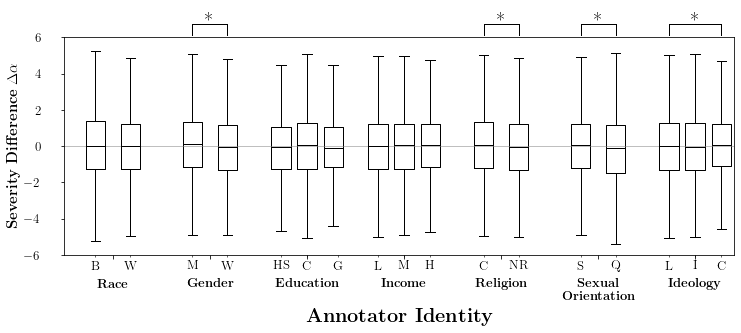

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

width = 0.2
spacing = 0.18

# Race
ax.boxplot(
    x=[b_annotator_diffs, w_annotator_diffs],
    positions=[-spacing, spacing],
    showfliers=False,
    widths=width,
    medianprops={'color': 'black', 'lw': 1},
    boxprops={'lw': 1})
# Gender
ax.boxplot(
    x=[m_annotator_diffs, f_annotator_diffs],
    positions=[1 - spacing, 1 + spacing],
    showfliers=False,
    widths=width,
    medianprops={'color': 'black', 'lw': 1},
    boxprops={'lw': 1},)
mplego.labels.add_significance_label(ax, bounds=[1-spacing, 1+spacing], which='top', label='*')

# Education
ax.boxplot(
    x=[hs_annotator_diffs, col_annotator_diffs, grad_annotator_diffs],
    positions=[2 - 1.5 * spacing, 2, 2 + 1.5 * spacing],
    showfliers=False,
    widths=width,
    medianprops={'color': 'black', 'lw': 1},
    boxprops={'lw': 1},)
# Income
ax.boxplot(
    x=[li_annotator_diffs, mi_annotator_diffs, hi_annotator_diffs],
    positions=[3 - 1.5 * spacing, 3, 3 + 1.5 * spacing],
    showfliers=False,
    widths=width,
    medianprops={'color': 'black', 'lw': 1},
    boxprops={'lw': 1},)
# Religion
ax.boxplot(
    x=[ch_annotator_diffs, nr_annotator_diffs],
    positions=[4 - spacing, 4 + spacing],
    showfliers=False,
    widths=width,
    medianprops={'color': 'black', 'lw': 1},
    boxprops={'lw': 1},)
mplego.labels.add_significance_label(ax, bounds=[4 - spacing, 4 + spacing], which='top', label='*')

# Sexual Orientation
ax.boxplot(
    x=[st_annotator_diffs, q_annotator_diffs],
    positions=[5 - spacing, 5 + spacing],
    showfliers=False,
    widths=width,
    medianprops={'color': 'black', 'lw': 1},
    boxprops={'lw': 1},)
mplego.labels.add_significance_label(ax, bounds=[5 - spacing, 5 + spacing], which='top', label='*')

# Ideology
ax.boxplot(
    x=[lib_annotator_diffs, neu_annotator_diffs, con_annotator_diffs],
    positions=[6 - 1.5 * spacing, 6, 6 + 1.5 * spacing],
    showfliers=False,
    widths=width,
    medianprops={'color': 'black', 'lw': 1},
    boxprops={'lw': 1},)
mplego.labels.add_significance_label(ax, bounds=[6 - 1.5 * spacing, 6 + 1.5 * spacing], which='top', label='*')

ax.axhline(0, linestyle='-', color='gray', lw=0.5)

ax.set_xticks([
    -spacing,
    spacing,
    1 - spacing,
    1 + spacing,
    2 - 1.5 * spacing,
    2.0001,
    2.045+ 1.5 * spacing,
    3 - 1.5 * spacing,
    3.0001,
    3 + 1.5 * spacing,
    4 - spacing,
    4 + spacing,
    5 - spacing,
    5 + spacing,
    6 - 1.5 * spacing,
    6.0001,
    6 + 1.5 * spacing
], minor=True)
ax.set_xticklabels(['B', 'W', 'M', 'W', 'HS', 'C', 'G', 'L', 'M', 'H', 'C', 'NR', 'S', 'Q', 'L', 'I', 'C'], minor=True)
ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
xticks = mplego.labels.bold_text(['Race', 'Gender', 'Education', 'Income', 'Religion', 'Sexual Ori.', 'Ideology'])
xticks[-2] = r'\textbf{Sexual}''\n'r'\textbf{Orientation}'
ax.set_xticklabels(xticks)
ax.tick_params(labelsize=13, which='major', pad=20)
ax.tick_params(labelsize=13, which='minor')
ax.set_xlim([-0.5, 6.4])
ax.set_ylim([-6, 6])
ax.set_ylabel(r'\textbf{Severity Difference} $\Delta \alpha$', fontsize=15)
ax.set_xlabel(r'\textbf{Annotator Identity}', fontsize=20, labelpad=5)
plt.savefig('men_women.png', bbox_inches='tight', dpi=600)

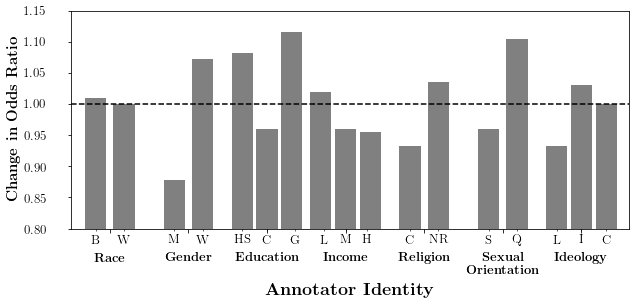

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

width = 0.2
spacing = 0.18

ax.bar(
    x=[-spacing, spacing,
       1 - spacing, 1 + spacing,
       2 - 1.75 * spacing, 2, 2 + 1.75 * spacing,
       3 - 1.75 * spacing, 3, 3 + 1.75 * spacing,
       4 - spacing, 4 + spacing,
       5 - spacing, 5 + spacing,
       6 - 1.75 * spacing, 6, 6 + 1.75 * spacing
      ],
    height=[np.exp(np.median(-b_annotator_diffs)), np.exp(np.median(-w_annotator_diffs)),
            np.exp(np.median(-m_annotator_diffs)), np.exp(np.median(-f_annotator_diffs)),
            np.exp(np.median(-hs_annotator_diffs)), np.exp(np.median(-col_annotator_diffs)), np.exp(np.median(-grad_annotator_diffs)),
            np.exp(np.median(-li_annotator_diffs)), np.exp(np.median(-mi_annotator_diffs)), np.exp(np.median(-hi_annotator_diffs)),
            np.exp(np.median(-ch_annotator_diffs)), np.exp(np.median(-nr_annotator_diffs)),
            np.exp(np.median(-st_annotator_diffs)), np.exp(np.median(-q_annotator_diffs)),
            np.exp(np.median(-con_annotator_diffs)), np.exp(np.median(-neu_annotator_diffs)), np.exp(np.median(-lib_annotator_diffs))],
    width=1.5 * spacing,
    color='gray'
)

ax.set_xticks([
    -spacing,
    spacing,
    1 - spacing,
    1 + spacing,
    2 - 1.75 * spacing,
    2.0001,
    2.045+ 1.75 * spacing,
    3 - 1.5 * spacing,
    3.0001,
    3 + 1.5 * spacing,
    4 - spacing,
    4 + spacing,
    5 - spacing,
    5 + spacing,
    6 - 1.75 * spacing,
    6.0001,
    6 + 1.75 * spacing
], minor=True)
ax.set_xticklabels(['B', 'W', 'M', 'W', 'HS', 'C', 'G', 'L', 'M', 'H', 'C', 'NR', 'S', 'Q', 'L', 'I', 'C'], minor=True)
ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
xticks = mplego.labels.bold_text(['Race', 'Gender', 'Education', 'Income', 'Religion', 'Sexual Ori.', 'Ideology'])
xticks[-2] = r'\textbf{Sexual}''\n'r'\textbf{Orientation}'
ax.set_xticklabels(xticks)
ax.tick_params(labelsize=13, which='major', pad=20)
ax.tick_params(labelsize=13, which='minor')
ax.set_xlim([-0.5, 6.6])
ax.set_ylim([0.8, 1.15])
ax.axhline(1, color='black', linestyle='--')
ax.set_ylabel(r'\textbf{Change in Odds Ratio}', fontsize=15)
ax.set_xlabel(r'\textbf{Annotator Identity}', fontsize=18, labelpad=5)
plt.savefig('odds_ratio.png', bbox_inches='tight')

In [36]:
data[annotator_gender_col].value_counts()

1.0    140478
2.0    119080
3.0      1768
5.0      1118
4.0       208
Name: demo_gender, dtype: int64

In [37]:
annotator_gender

{'female': 1.0,
 'male': 2.0,
 'non-binary': 3.0,
 'self-describe': 4.0,
 'prefer_not_to_say': 5.0}

Text(0, 0.5, '\\textbf{Severity Difference}')

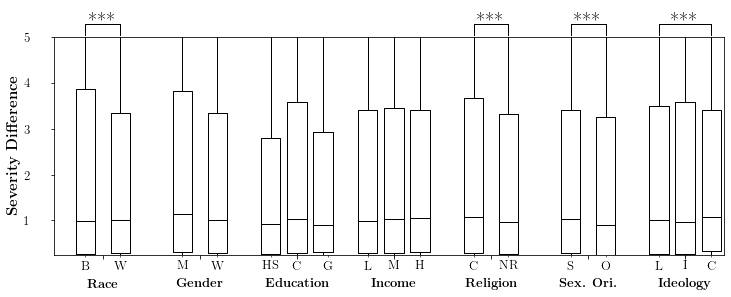

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

width = 0.2
spacing = 0.18

# Race
ax.boxplot(
    x=[np.exp(b_annotator_diffs), np.exp(w_annotator_diffs)],
    positions=[-spacing, spacing],
    showfliers=False,
    widths=width,
    medianprops={'color': 'black', 'lw': 1},
    boxprops={'lw': 1})
mplego.labels.add_significance_label(ax, bounds=[-spacing, spacing], which='top', label='***')
# Gender
ax.boxplot(
    x=[np.exp(m_annotator_diffs), np.exp(w_annotator_diffs)],
    positions=[1 - spacing, 1 + spacing],
    showfliers=False,
    widths=width,
    medianprops={'color': 'black', 'lw': 1},
    boxprops={'lw': 1},)
# Education
ax.boxplot(
    x=[np.exp(hs_annotator_diffs), np.exp(col_annotator_diffs), np.exp(grad_annotator_diffs)],
    positions=[2 - 1.5 * spacing, 2, 2 + 1.5 * spacing],
    showfliers=False,
    widths=width,
    medianprops={'color': 'black', 'lw': 1},
    boxprops={'lw': 1},)
# Income
ax.boxplot(
    x=[np.exp(li_annotator_diffs), np.exp(mi_annotator_diffs), np.exp(hi_annotator_diffs)],
    positions=[3 - 1.5 * spacing, 3, 3 + 1.5 * spacing],
    showfliers=False,
    widths=width,
    medianprops={'color': 'black', 'lw': 1},
    boxprops={'lw': 1},)
# Religion
ax.boxplot(
    x=[np.exp(ch_annotator_diffs), np.exp(nr_annotator_diffs)],
    positions=[4 - spacing, 4 + spacing],
    showfliers=False,
    widths=width,
    medianprops={'color': 'black', 'lw': 1},
    boxprops={'lw': 1},)
mplego.labels.add_significance_label(ax, bounds=[4 - spacing, 4 + spacing], which='top', label='***')

# Sexual Orientation
ax.boxplot(
    x=[np.exp(st_annotator_diffs), np.exp(q_annotator_diffs)],
    positions=[5 - spacing, 5 + spacing],
    showfliers=False,
    widths=width,
    medianprops={'color': 'black', 'lw': 1},
    boxprops={'lw': 1},)
mplego.labels.add_significance_label(ax, bounds=[5 - spacing, 5 + spacing], which='top', label='***')

# Ideology
ax.boxplot(
    x=[np.exp(lib_annotator_diffs), np.exp(neu_annotator_diffs), np.exp(con_annotator_diffs)],
    positions=[6 - 1.5 * spacing, 6, 6 + 1.5 * spacing],
    showfliers=False,
    widths=width,
    medianprops={'color': 'black', 'lw': 1},
    boxprops={'lw': 1},)
mplego.labels.add_significance_label(ax, bounds=[6 - 1.5 * spacing, 6 + 1.5 * spacing], which='top', label='***')

ax.axhline(0, linestyle='-', color='gray', lw=0.5)

ax.set_xticks([
    -spacing,
    spacing,
    1 - spacing,
    1 + spacing,
    2 - 1.5 * spacing,
    2.0001,
    2.045+ 1.5 * spacing,
    3 - 1.5 * spacing,
    3.0001,
    3 + 1.5 * spacing,
    4 - spacing,
    4 + spacing,
    5 - spacing,
    5 + spacing,
    6 - 1.5 * spacing,
    6.0001,
    6 + 1.5 * spacing
], minor=True)
ax.set_xticklabels(['B', 'W', 'M', 'W', 'HS', 'C', 'G', 'L', 'M', 'H', 'C', 'NR', 'S', 'O', 'L', 'I', 'C'], minor=True)
ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
ax.set_xticklabels(
    mplego.labels.bold_text(['Race', 'Gender', 'Education', 'Income', 'Religion', 'Sex. Ori.', 'Ideology']))
ax.tick_params(labelsize=13, which='major', pad=20)
ax.tick_params(labelsize=13, which='minor')
ax.set_xlim([-0.5, 6.4])
ax.set_ylim([0.25, 5])
ax.set_ylabel(r'\textbf{Severity Difference}', fontsize=15)